In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
df = pd.read_csv('./GOLD_H1_201401020900_202312070800.csv',sep='\t')
df

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2014.01.02,09:00:00,1225.05,1228.42,1220.52,1222.86,3523,0,0
1,2014.01.02,10:00:00,1222.86,1223.91,1219.66,1221.65,2353,0,0
2,2014.01.02,11:00:00,1221.66,1221.96,1219.10,1221.26,2038,0,0
3,2014.01.02,12:00:00,1221.29,1221.83,1219.26,1221.25,1500,0,0
4,2014.01.02,13:00:00,1221.25,1221.46,1216.51,1217.95,2973,0,0
...,...,...,...,...,...,...,...,...,...
58880,2023.12.07,04:00:00,2026.08,2029.87,2026.04,2028.95,3594,0,30
58881,2023.12.07,05:00:00,2028.90,2029.78,2026.36,2026.76,3409,0,26
58882,2023.12.07,06:00:00,2026.70,2026.95,2025.24,2025.92,2731,0,26
58883,2023.12.07,07:00:00,2025.83,2027.23,2025.11,2026.66,3197,0,26


In [3]:
df.columns

Index(['<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>',
       '<VOL>', '<SPREAD>'],
      dtype='object')

In [4]:
df.describe()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
count,58885.000000,58885.000000,58885.000000,58885.000000,58885.000000,5.888500e+04,58885.000000
mean,1486.987253,1488.787756,1485.156028,1487.002351,4387.026730,5.616019e+13,30.835561
std,291.542513,292.010318,291.025572,291.548730,4309.246894,2.763920e+14,11.246721
min,1049.960000,1050.580000,1046.290000,1049.960000,1.000000,0.000000e+00,0.000000
25%,1245.190000,1246.470000,1244.010000,1245.190000,1674.000000,0.000000e+00,25.000000
50%,1327.810000,1329.130000,1326.510000,1327.800000,3215.000000,0.000000e+00,32.000000
75%,1792.230000,1794.170000,1790.290000,1792.250000,5495.000000,0.000000e+00,38.000000
max,2117.400000,2144.630000,2090.600000,2117.370000,102129.000000,4.009700e+15,397.000000


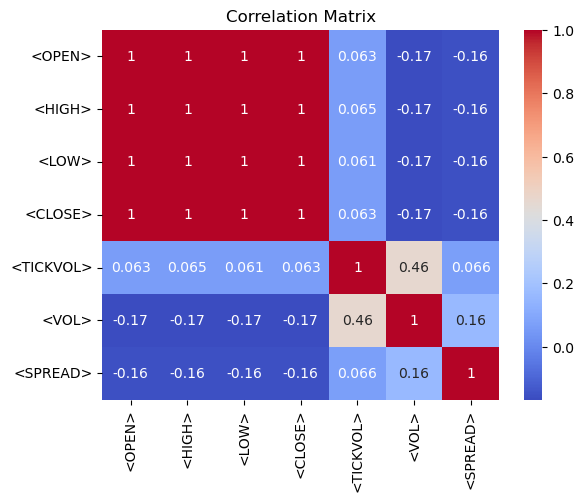

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.drop(["<DATE>", "<TIME>"], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [6]:
df.isnull().sum()

<DATE>       0
<TIME>       0
<OPEN>       0
<HIGH>       0
<LOW>        0
<CLOSE>      0
<TICKVOL>    0
<VOL>        0
<SPREAD>     0
dtype: int64

In [7]:
for column in df.columns:
    print(column, df[column].nunique())

<DATE> 2565
<TIME> 24
<OPEN> 37646
<HIGH> 37691
<LOW> 37842
<CLOSE> 37667
<TICKVOL> 13119
<VOL> 2765
<SPREAD> 148


In [8]:
df.sample(10)

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
33882,2019.09.13,09:00:00,1497.41,1505.86,1497.31,1504.82,2659,0,31
15356,2016.07.22,10:00:00,1325.99,1326.12,1322.00,1323.17,7325,0,40
13535,2016.04.01,19:00:00,1214.01,1218.01,1212.93,1216.57,5551,0,40
46894,2021.11.29,08:00:00,1795.73,1796.62,1794.49,1794.85,2448,0,35
34563,2019.10.24,23:00:00,1501.91,1503.85,1501.91,1503.53,791,0,24
44746,2021.07.20,11:00:00,1813.71,1813.79,1811.51,1813.01,14643,0,26
28040,2018.09.17,03:00:00,1193.30,1193.80,1192.69,1193.72,934,0,30
52011,2022.10.10,13:00:00,1680.36,1681.19,1677.43,1679.12,4966,0,25
50223,2022.06.22,15:00:00,1836.38,1846.65,1836.04,1844.59,9421,0,25
30477,2019.02.15,16:00:00,1317.36,1319.85,1316.23,1316.73,4116,0,26


## Merge date and time

In [9]:
def convert_datetime(df):
    df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'], format='%Y.%m.%d %H:%M:%S')
    df = df.drop(["<DATE>", "<TIME>"], axis=1)
    return df

df = convert_datetime(df)
df.set_index('<DATETIME>', inplace=True)
df

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
<DATETIME>,,,,,,,
2014-01-02 09:00:00,1225.05,1228.42,1220.52,1222.86,3523,0,0
2014-01-02 10:00:00,1222.86,1223.91,1219.66,1221.65,2353,0,0
2014-01-02 11:00:00,1221.66,1221.96,1219.10,1221.26,2038,0,0
2014-01-02 12:00:00,1221.29,1221.83,1219.26,1221.25,1500,0,0
2014-01-02 13:00:00,1221.25,1221.46,1216.51,1217.95,2973,0,0
...,...,...,...,...,...,...,...
2023-12-07 04:00:00,2026.08,2029.87,2026.04,2028.95,3594,0,30
2023-12-07 05:00:00,2028.90,2029.78,2026.36,2026.76,3409,0,26
2023-12-07 06:00:00,2026.70,2026.95,2025.24,2025.92,2731,0,26


# Resampling

In [10]:
df = df.resample('D').mean().ffill()

## Bad and unwanted column

In [11]:
df[df["<VOL>"] != 0]

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
<DATETIME>,,,,,,,
2017-02-02,1216.279565,1217.935217,1214.795652,1216.558261,7774.782609,3.690217e+14,40.043478
2017-02-03,1214.880435,1216.430000,1213.453043,1215.083913,11744.304348,1.174300e+15,40.000000
2017-02-04,1214.880435,1216.430000,1213.453043,1215.083913,11744.304348,1.174300e+15,40.000000
2017-02-05,1214.880435,1216.430000,1213.453043,1215.083913,11744.304348,1.174300e+15,40.000000
2017-02-06,1225.754783,1227.383043,1224.963913,1226.436957,12286.434783,1.228561e+15,40.000000
...,...,...,...,...,...,...,...
2017-08-02,1267.572609,1268.653043,1266.302609,1267.483478,12787.391304,1.278739e+15,40.000000
2017-08-03,1264.863913,1266.009565,1263.676522,1264.957826,13078.173913,1.307817e+15,40.000000
2017-08-04,1264.928261,1265.805217,1263.670000,1264.483913,11828.652174,1.182865e+15,40.000000


In [12]:
df = df.drop(["<VOL>", "<SPREAD>", "<TICKVOL>"], axis=1)
df

,<OPEN>,<HIGH>,<LOW>,<CLOSE>
<DATETIME>,,,,
2014-01-02,1223.003333,1225.080000,1220.582000,1222.967333
2014-01-03,1231.911667,1234.353750,1230.357917,1232.418750
2014-01-04,1231.911667,1234.353750,1230.357917,1232.418750
2014-01-05,1231.911667,1234.353750,1230.357917,1232.418750
2014-01-06,1239.648261,1241.644783,1236.671739,1239.687391
...,...,...,...,...
2023-12-03,2046.710000,2050.298696,2044.820435,2048.136087
2023-12-04,2063.921739,2069.710435,2056.323913,2062.012609
2023-12-05,2027.166087,2030.146957,2024.371304,2026.744348


# Drop  OPEN HIGH LOW because correlation is super high

In [13]:
df = df.drop(["<OPEN>", "<HIGH>", "<LOW>"], axis=1)

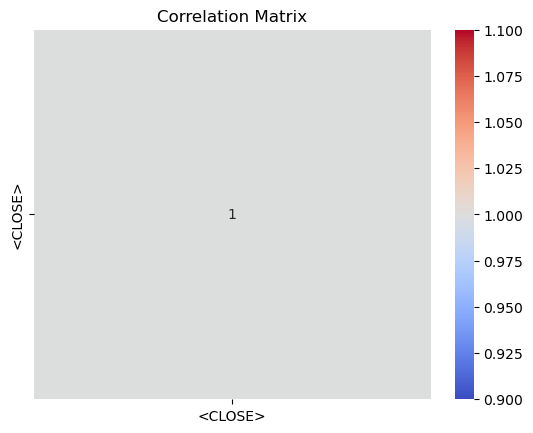

In [14]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# DATA OVERVIEW

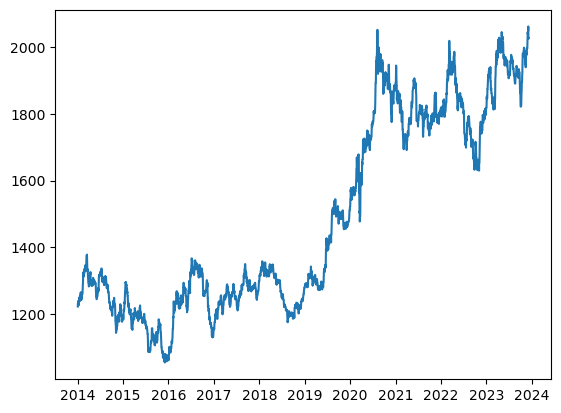

In [15]:
plt.plot(df['<CLOSE>'])

# Prepare data for supervised learning

In [16]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X
X,Y = create_features(df, label='<CLOSE>')

## Split dataset

In [17]:
# split a univariate dataset into train/test sets
x_train_full, x_test, y_train_full, y_test = train_test_split(X, Y, test_size = 0.1, random_state=42,shuffle=False) # test must not be shuffle
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.3, random_state=42, shuffle=True)

## XGB model

In [18]:
xgb_params_grid = param_dist = {
    'max_depth': [4,8,16,32,64],
    'learning_rate': [ 0.01, 0.1 ],
    'subsample': np.linspace(0.5, 1, 4),
    'n_estimators': [25, 50, 100],
}
xgb_grid = GridSearchCV(XGBRegressor(), xgb_params_grid, n_jobs=-1, verbose=1)

In [19]:
xgb_grid.fit(x_train, y_train,
        eval_set=[(x_val, y_val)],
       verbose=False)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [4, 8, 16, 32, 64],
                         'n_estimators': [25, 50, 100],
                         'subsample': array([0.5       , 0.66666667, 0.83333333, 1.        ])},
             verbose=1)

In [20]:
y_pred_xgb = xgb_grid.predict(x_test)

In [21]:
xgb_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 32,
 'n_estimators': 100,
 'subsample': 0.8333333333333333}

## Random forrest

In [22]:
rf_params_grid = {
    'max_depth': [25,50,100,200],
    'n_estimators': [25, 50, 100],
}

rf_grid = GridSearchCV(RandomForestRegressor(), rf_params_grid,cv=5, n_jobs=-1, verbose=1)

In [23]:
rf_grid.fit(x_train_full, y_train_full)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [25, 50, 100, 200],
                         'n_estimators': [25, 50, 100]},
             verbose=1)

In [24]:
y_pred_tree = rf_grid.predict(x_test)

In [25]:
rf_grid.best_params_

{'max_depth': 200, 'n_estimators': 25}

# Linear regression

In [26]:
linear_params_grid = {
    'fit_intercept': [True, False],
}
linear_grid = GridSearchCV(LinearRegression(), linear_params_grid, n_jobs=-1, verbose=1)
linear_grid.fit(x_train_full, y_train_full)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False]}, verbose=1)

In [27]:
linear_pred = linear_grid.predict(x_test)

In [28]:
linear_grid.best_params_

{'fit_intercept': True}

# Predicting a totally unseen data

In [29]:
def showResult(y_pred):
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R2 Score:', r2_score(y_test, y_pred))

    plt.plot(pd.DataFrame({"Predicted":y_pred} ,index=y_test.index) , label='Predicted')
    plt.plot(y_test, label='Real')
    plt.legend()
    plt.show()

Mean Absolute Error: 141.873305627641
Mean Squared Error: 28037.292465068753
R2 Score: -5.880117915793449


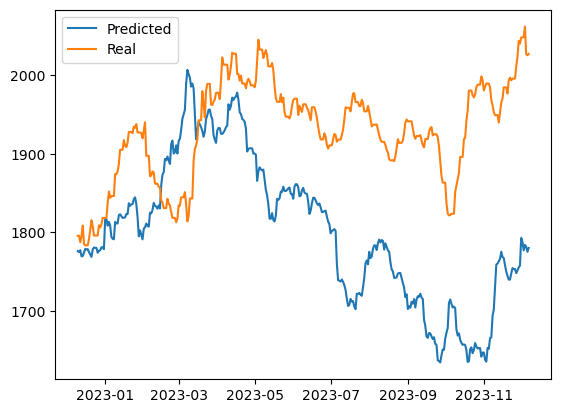

In [30]:
showResult(y_pred_xgb)

Mean Absolute Error: 142.02754801373416
Mean Squared Error: 27969.206660502357
R2 Score: -5.863410226761347


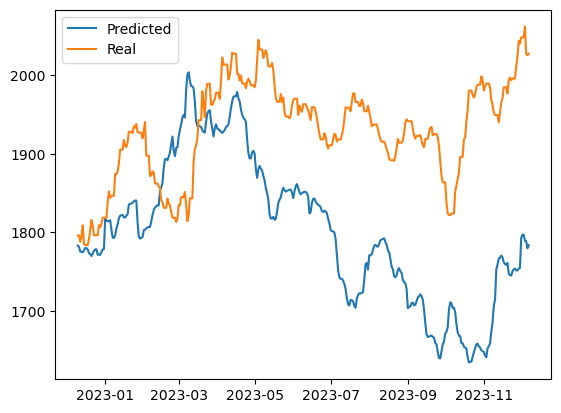

In [31]:
showResult(y_pred_tree)

Mean Absolute Error: 73.77623924329916
Mean Squared Error: 7761.391528859623
R2 Score: -0.9045807998658921


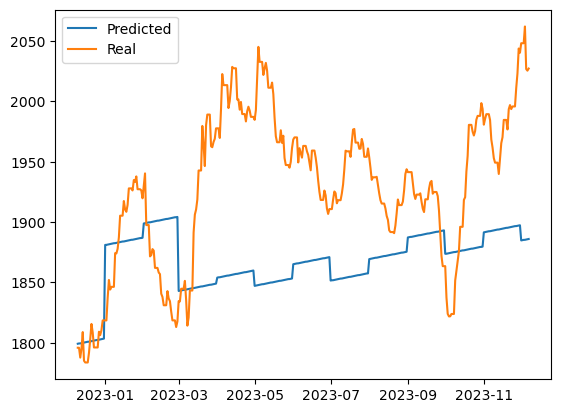

In [32]:
showResult(linear_pred)